# Datos simulados TFM
### Autor: Jaime Carreto Sánchez
### Fecha: 26 de Abril de 2025
### jaime.carretos@um.es


### Introducción

En este notebook se simula un conjunto de datos con el objetivo de estudiar el impacto de variables confusoras (`C`) sobre la relación entre un conjunto de predictores (`M`) y una variable objetivo primaria (`Y`). Este enfoque se basa en un marco casual donde ciertas variables clínicas como la edad o el sexo influyen tanto en  algunas variables predictoras aunque no todas (`M'`) como en el estado de la enfermedad, que es la variable objetivo primaria, lo que puede inducir correlaciones espurias dificiles de indentificar si no se controlan adecuadamente.

El objetivo es crear un escenario en el que:

- Algunas variables `C` afectan directamente a un subconjunto `M'` de genes simulados, por ejemplo (edad, sexo, hábitos, etc).

- La variables `M` que representaran expresión génica simulada y que a su vez están formadas por:

    -`M'`: Representa un subconjunto de genes que están afectados por `C`.

    - `Ruido`: Genes aleatorios no relacionados con `C` ni con la variable objetivo
    
- `Y`: Variable binaria que representa el estado de una enfermedad simulada.

La estructura casual que queremos modelar es la siguiente: C → M’ → y.

Es decir, ciertas variables clínicas (`C`) afectan a la expresión de algunos genes (`M'`), y a su vez, la variable de enfermedad (`Y`) se genera como una función de ese subconjunto de (`M`). El resto de genes (`M`) simulan ruido de fondo, común en datos ómicos reales.

### Objetivos del experimento

- Evaluar como afecta la colinealidad entre `C` y `M'` a la capacidad predictiva del modelo

- Observar si es posible detectar efectos falsos inducidos por la confusión (C actuando sobre M e Y)

- Explorar estrategias de modelado, como `always.split.variables`, para mejorar la interpretabilidad y el control del sesgo de confusión en modelo tipo Random Forest.

### Simulación de variables confusoras (`C`)

En este paso se generan las variables del conjunto `C`, que representan características clínicas o demográficas de los individuos, como edad, sexo, lote o rin. Estas variables no son genes, sino factores personales que podrían influir en la expresión génica de (`M`) y, de forma indirecta, en la enfermedad (`Y`).

En el contexto del modelo casual, `C` actúa como conjunto de **variables confusoras**. Algunas de ellas afectarán directamente a un subconjunto de genes (`M'`), y estos genes, a su vez, influirán en `Y`. Otras variables de `C` no tendrán ningún efecto real, lo que nos permitirá estudiar si el modelo logra distinguir señal de ruido confusor.

Las variables simuladas serán:

- **Edad**: Variable continua normlamente distribuida (media 60, mi 40, max 85).

- **RIN**: Continua (media 6, min 0, max 10).

- **Sexo**: Binaria, simulada a partir de la normal (0,1) con corte en 0

- **Lote**: Categórica con 4 niveles (simulada con 3 cortes sobre normal)

A continuación, se simulan estas variables para una cohorte de 4000 individuos. 


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

In [2]:

n_samples= 4000
np.random.seed(42) 


edad= np.round(np.clip(np.random.normal(loc=60, scale=7.5, size=n_samples), 40, 85)).astype(int)

rin= np.clip(np.random.normal(loc=0, scale=2, size=n_samples), 0, 10)

sexo_raw= np.random.normal(0, 1, n_samples)
sexo = (sexo_raw > 0).astype(int) 

lote_raw= np.random.normal(0, 1, n_samples)
lote= pd.cut(
    lote_raw,
    bins=[-np.inf, -0.5, 0, 0.5, np.inf],
    labels=[0,1,2,3]
)

#Unimos todas las variables en en un DataFrame
df_c= pd.DataFrame({
    'edad': edad,
    'rin':rin,
    'sexo': sexo,
    'lote': lote
})

Ahora muestro las 5 primeras filas del `df_C` para ver el resultado

In [3]:
df_c.head()

,edad,rin,sexo,lote
0,64,0.000000,0,3
1,59,0.000000,0,0
2,65,0.036034,0,1
3,71,0.945261,1,1
4,58,0.000000,1,2


Ahora vamos a simular datos de expresión génica `M` para los 4000 sujetos. Queremos que las variables (genes) tengan una **estructura de correlación interna** realista, y además, que algunos de esos genes estén **relacionados casualmente con algunas variables clínicas** `C` (edad y sexo).

Esto es fundamental para reflejar un escenario biomédico realista donde:

- Algunos genes están correlacionados entre sí (forman redes de coexpresión)

- Algunos genes están influidos por covariables como edad o sexo

- Otros genes son simplemente `ruido` (sin relación con nada)

Voy a generar cuatro grupos:

- El grupo `A` que tendrá 100 genes, que tiene una correlación interna de [0.3, 0.6] y está correlacionado con edad (p = 0.4)

- El grupo `B` que tendrá 200 genes, con una correlación interna del [0.2, 0.4] y corellacionado con sexo (p = 0.4)

- El grupo `D` que tiene 300 genes con una correlación interna de [0.2, 0.3] y sin relación con ninguna variable de `C`

- El grupo `Ruido` que contendrá 400 genes no correlacionados entre sí y tampoco correlacionados con `C`.

In [4]:
n_samples = 4000 
n_genes= 1000 

Sigma= np.eye(n_genes) 

#Ahora defino las correlaciones internas

#Grupo A

for i in range(0, 100):
    for j in range(i+1, 100):
        corr=np.random.uniform(0.3, 0.6)
        Sigma[i,j] = Sigma[j, i] = corr

#Grupo B
for i in range (100, 300):
    for j in range(i+1,300):
        corr= np.random.uniform(0.2, 0.4)
        Sigma[i,j] = Sigma[j, i] = corr

 # Grupo D
for i in range(300, 600):
    for j in range(i+1, 600):
        corr= np.random.uniform(0.2, 0.3)
        Sigma[i,j] = Sigma[j,i] = corr

Ahora voy a simular que la variable **edad** afecte al grupo de genes `A` y la variable **sexo** afecte al grupo de genes `B`. Primero es necesario estandarizar las variables `edad` y `sexo` a media 0 y varianza 1

In [5]:

scaler = StandardScaler()
edad_scaled= scaler.fit_transform(df_c[['edad']]).flatten()
sexo_scaled= scaler.fit_transform(df_c[['sexo']]).flatten()

Ahora que ya tenemos:
- Una matriz de correlaciones entre genes `M`
- Las variables `edad` y `sexo` estandarizadas (`edad_scaled`, `sexo_scaled`)

Nustro objetivo es:
- Simular datos de expresión génica para las 4000 sujetos, respetando la estructura `sigma` que hemos definido
- Añadir la influencia directa de `edad` sobre el grupo `A` y de `sexo` sobre el grupo `B`, forzando una correlación del 0.4 en ambos casos


In [6]:
# Genero datos de expresión génica multivariados basados en las matrig Sigma
M_raw= np.random.multivariate_normal(
    mean= np.zeros(n_genes), 
    cov= Sigma, 
    size=n_samples 
)
target_corr= 0.4

#Inyecto la influencia de edad en los genes del grupo A
for i in range(0, 100):
    M_raw[:, i] = (M_raw[:, i] + target_corr * edad_scaled) / np.sqrt(1 + target_corr**2)

# Inyecto la influencia de sexo en los genes B
for i in range(100, 300):
    M_raw[:,i]= (M_raw[:,i] + target_corr * sexo_scaled) / np.sqrt(1+ target_corr**2)


/tmp/ipykernel_6748/1859435274.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  M_raw= np.random.multivariate_normal(


Ahora que tenemos la matriz de expresión génica `M_raw` y las variables clínicas `C`, vamos a construir una **variable  objetivo Y** que simule si el individuo tiene la enfermedad o no.

Queremos que `Y` dependa de:

- Los genes del grupo `A` (poca influencia, correlación de 0.2)
- Los genes del grupo `B` (mucha influencia, correlación de 0.5)
- La `edad` (correlación de 0.3)
- El `sexo` (correlación de 0.1)

De esta forma, `Y` será una función de:

- Variables clínicas + genes influenciadas por ellas + genes independientes

Así modelamos la **confusión real (C → M' → Y)**

In [7]:
#Defino los pesos de influencia para cada componente
peso_A= 0.2
peso_B= 0.5
peso_edad= 0.3
peso_sexo= 0.1

# Calculo la contribución de los genes A y B
contribucion_A = np.mean(M_raw[:, :100], axis=1)
contribucion_B = np.mean(M_raw[:, 100:300], axis= 1)

# Combino todas las contribuciones
score_continuo= (
    peso_A * contribucion_A +
    peso_B * contribucion_B +
    peso_edad * edad_scaled +
    peso_sexo * sexo_scaled +
    np.random.normal(0,0.05, n_samples) #Ruido adicional
)
#Convertir el score continuo en una variable binaria
Y = (score_continuo > np.median(score_continuo)).astype(int) # Si el score es mayor que la mediana, clasificamos como 1 (enfermo), si es menor o igual, como sano (0)


Ahora que ya hemos definido la variable `Y` vamos a construir el **Dataframe final**, juntando:

- Variables clínicas `C`
- Matriz de expresión génica `M`
- Variable objetivo `Y`


In [8]:
# Crear nombres de genes numerados por grupo
gene_name = []

# Grupo A
for i in range(1, 101):
    gene_name.append(f'A_gene{i}')

# Grupo B
for i in range(1, 201):
    gene_name.append(f'B_gene{i}')

# Grupo D
for i in range(1, 301):
    gene_name.append(f'D_gene{i}')

# Grupo Ruido
for i in range(1, 401):
    gene_name.append(f'Noise_gene{i}')

df_genes= pd.DataFrame(
    M_raw, 
    columns= gene_name
)

df_Y= pd.DataFrame({'Alzheimer': Y})

df_final= pd.concat([df_genes,df_c, df_Y], axis=1)
df_final.head()

,A_gene1,A_gene2,A_gene3,A_gene4,A_gene5,A_gene6,A_gene7,A_gene8,A_gene9,A_gene10,...,Noise_gene396,Noise_gene397,Noise_gene398,Noise_gene399,Noise_gene400,edad,rin,sexo,lote,Alzheimer
0,-0.111782,0.096894,1.798425,-0.093378,-0.197196,-1.260852,-1.064165,0.076846,-0.999928,0.111733,...,0.389066,-0.743105,0.394847,0.513076,0.379261,64,0.000000,0,3,1
1,-0.492161,-1.072408,-0.860142,-0.398714,-2.343186,-1.838545,-0.519876,-0.704514,-1.864341,-0.981870,...,-0.495361,-1.089365,-1.364647,0.727354,-2.073535,59,0.000000,0,0,0
2,1.332466,0.910919,-0.140499,-0.145921,0.754266,1.467025,-0.975835,-0.037692,0.041408,0.014781,...,-1.962062,-1.628818,-0.529797,-0.795717,-0.686563,65,0.036034,0,1,1
3,-0.504016,-1.143588,-0.157091,-1.244918,-2.690703,1.769546,-0.999807,-0.077874,-0.925741,0.968286,...,0.709577,0.008303,0.394584,1.825892,-0.195937,71,0.945261,1,1,1
4,0.423454,0.772922,1.157203,2.399593,0.416823,0.023914,2.028943,-0.182201,-0.560607,0.112476,...,1.381980,-0.668845,-0.253458,-2.737713,0.412207,58,0.000000,1,2,1


### Comprobaciones

Ahora que se ha creado el Dataframe final, voy a hacer una serie de comprobaciones para observar los valores de correlación entre las variables y los genes. Voy a comprobar la correlación de:

- `Edad` con los genes del grupo A, que debería estar alrededor de 0.4.
- `Sexo` con los genes del grupo B, también alrededor de 0.4. 
- `Edad` con Y (alrededor de 0.3)
- `Sexo` con Y (alrededor de 0.1)
- Genes del grupo A con Y (alrededor de 0.2)
- Genes del grupo B con Y (alrededor de 0.5)

In [9]:
# Calculo todas las correlaciones entre los genes y la variable de interés
# Edad genes A
correlaciones_edad_genesA = [np.corrcoef(df_final['edad'], df_final[f'A_gene{i}'])[0,1] for i in range(1, 101)]
# Sexo genes B
correlaciones_sexo_genesB = [np.corrcoef(df_final['sexo'], df_final[f'B_gene{i}'])[0,1] for i in range(1, 201)]
# Edad - Y
corr_edad_y= np.corrcoef(df_final['edad'], df_final['Alzheimer'])[0,1]
# Sexo - Y
corr_sexo_y= np.corrcoef(df_final['sexo'], df_final['Alzheimer'])[0,1]
# Grupo A - Y
corr_genesA_y= [np.corrcoef(df_final[f'A_gene{i}'], df_final['Alzheimer'])[0,1] for i in range(1, 101)]
# Grupo B - Y
corr_genesB_y= [np.corrcoef(df_final[f'B_gene{i}'], df_final['Alzheimer'])[0,1] for i in range(1, 201)]
# Correlación entre Edad y Genes B
correlaciones_edad_genesB = [np.corrcoef(df_final['edad'], df_final[f'B_gene{i}'])[0,1] for i in range(1, 201)]
# Correlación entre Sexo y Genes A
correlaciones_sexo_genesA = [np.corrcoef(df_final['sexo'], df_final[f'A_gene{i}'])[0,1] for i in range(1, 101)]
# Correlación entre Edad y Genes D
correlaciones_edad_genes_D = [np.corrcoef(df_final['edad'], df_final[f'D_gene{i}'])[0,1] for i in range(1,301)]
# Correlación entre Sexo y Genes D
correlaciones_sexo_genes_D = [np.corrcoef(df_final['sexo'], df_final[f'D_gene{i}'])[0,1] for i in range(1,301)]


#Imprimo los resultados
print(f"Media correlación edad - genes A: {np.mean(correlaciones_edad_genesA):.3f}")
print(f"Media correlación sexo - genes B: {np.mean(correlaciones_sexo_genesB):.3f}")
print(f"Correlación edad - Alzheimer: {corr_edad_y:.3f}")
print(f"Correlación sexo - Alzheimer: {corr_sexo_y:.3f}")
print(f"Media correlación genes A - Alzheimer: {np.mean(corr_genesA_y):.3f}")
print(f"Media correlación genes B - Alzheimer: {np.mean(corr_genesB_y):.3f}")
print(f"Media correlación edad - genes B: {np.mean(correlaciones_edad_genesB):.3f}")
print(f"Media correlación sexo - genes A: {np.mean(correlaciones_sexo_genesA):.3f}")
print(f"Media correlación edad - genes D: {np.mean(correlaciones_edad_genes_D):.3f}")
print(f"Media correlación sexo - genes D: {np.mean(correlaciones_sexo_genes_D):.3f}")

Media correlación edad - genes A: 0.328
Media correlación sexo - genes B: 0.362
Correlación edad - Alzheimer: 0.513
Correlación sexo - Alzheimer: 0.473
Media correlación genes A - Alzheimer: 0.275
Media correlación genes B - Alzheimer: 0.339
Media correlación edad - genes B: 0.001
Media correlación sexo - genes A: 0.004
Media correlación edad - genes D: 0.003
Media correlación sexo - genes D: 0.002


Ahora genero un `BoxPlot` para ver si efectivamente, las correlaciones de `edad` con los genes A están en el rango esperado, y lo mismo para `sexo` con los genes B.

/tmp/ipykernel_6748/4112491699.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grupo', y='correlacion', data=df_corr_total, palette='Set2')


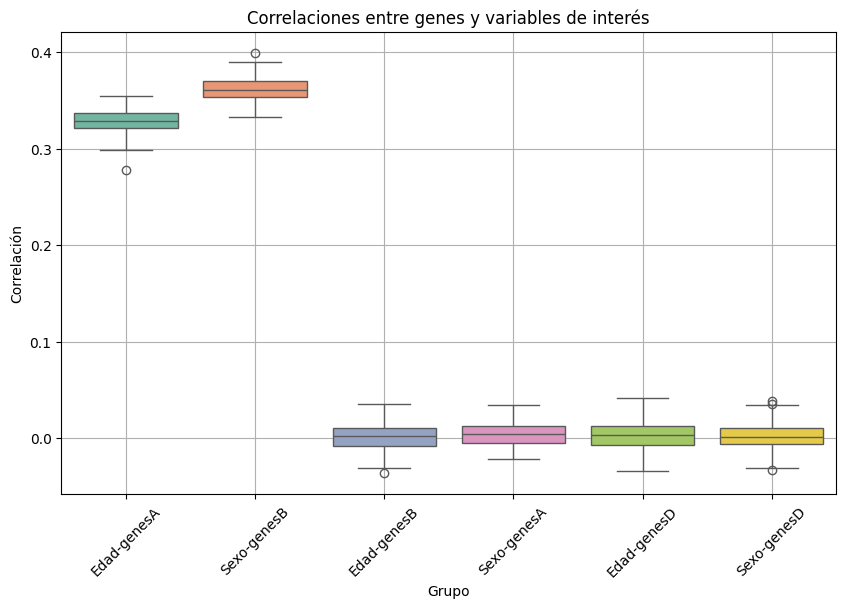

In [10]:

df_corr_edad_genesA= pd.DataFrame({
    'correlacion': correlaciones_edad_genesA,
    'grupo': 'Edad-genesA'
})

df_corr_sexo_genesB= pd.DataFrame({
    'correlacion': correlaciones_sexo_genesB,
    'grupo': 'Sexo-genesB'
})

df_corr_edad_genesB= pd.DataFrame({
    'correlacion': correlaciones_edad_genesB,
    'grupo': 'Edad-genesB'
})

df_corr_sexo_genesA = pd.DataFrame({
    'correlacion': correlaciones_sexo_genesA,
    'grupo': 'Sexo-genesA'
})

df_corr_edad_genesD = pd.DataFrame({
    'correlacion': correlaciones_edad_genes_D,
    'grupo': 'Edad-genesD'
})

df_corr_sexo_genesD = pd.DataFrame({
    'correlacion': correlaciones_sexo_genes_D,
    'grupo': 'Sexo-genesD'
})
df_corr_total= pd.concat([df_corr_edad_genesA, df_corr_sexo_genesB, df_corr_edad_genesB, df_corr_sexo_genesA, df_corr_edad_genesD, df_corr_sexo_genesD], axis=0)

plt.figure(figsize=(10, 6))
sns.boxplot(x='grupo', y='correlacion', data=df_corr_total, palette='Set2')
plt.title('Correlaciones entre genes y variables de interés')
plt.xlabel('Grupo')
plt.ylabel('Correlación')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

El gráfico anterior representa la distribución de las correlaciones entre:
- `Edad` y los genes del `grupo A`
- `Sexo` y los genes del `grupo B`
- `Edad` y los genes del `grupo B`
- `Sexo` y los genes del `grupo A`
- `Edad` y los genes del `Grupo D`
- `Sexo` y los genes del `Grupo D`

Cada punto en la distribución representa la correlación de un único gen con la variable clínica correspondiente

Los resultados muestran:
-**Edad-Genes A**: Las correlaciones se agrupan en torno a valores entre 0.3 y 0.35, con una media cercana al 0.33. Esto confirma que los genes del `grupo A` están moderadamente correlacionados con la edad, como se había definido en el modelo teórico. La ligera desviación se debe al efecto combinado de la estandarización y la inyección de ruido.

-**Sexo-Genes B**: Las correlaciones con sexo están agrupadas alrededor de 0.36, con una variabilidad algo mayor que en el `grupo A`. Esto es consistente con lo definido (correlación de 0.4). La distribución está sesgada hacia valores más altos, lo cuál también es esperable debido a como se combinan la codificación binaria de sexo y la normalización posterior.

-**Edad-GenesB, Sexo-GenesA, Edad-GenesD, Sexo-GenesD**: Presenta valores centrados cerca de 0 como era de esperar, ya que no se inntrodujo relación directa en el simulador. Aun así el valor no es exactamente cero, esto se puede deber a varios factores:

- **Variabilidad muestral**: Aunque la correlación sea 0, al generar una **muestra finita**, los valores obtenidos no será exactamente nulos. Es completamente normal que algunas correlaciones aparezcan como **ligeramente positivas o negativas** simplemente por azar estadístico.

- **Presencia de ruido aleatorio**: La variables de expresión génica incluyen **ruido gaussiano**,  y eso puede inducir pequeñas fluctuaciones en la correlaicón con variables con las que no deberían tener relación.

El gráfico demuestra que la inyección de correlación entre **edad-grupo A** y **sexo-grupo B** ha sido exitosa. Las correlaciones medias se alinean con lo definido en el diseño del experimento, y hay una coherencia estructural en ambos grupos. También se muestra como los demás grupos, a los que no se les ha añadido correlaciones entre ellos, efectivamente no muestran ningún grado de correlación, como es lógico, y refuerza aún más el correcto diseño del experimento.

### Correlaciones internas por grupo de genes

En esta sección analizamos **la correlación interna entre los genes dentro de cada grupo (A,B y D)**. Como se definió en la simulación, cada grupo de genes fue generado con un **rango específico de correlación**:

-**Grupo A**: Correlación interna de 0.3-0.6

-**Grupo B**: Correlación interna de 0.2-0.4

-**Grupo D**: Correlación interna entre 0.2 y 0.3

Para verificar que estas condiciones se han cumplido en los datos simulados, calculamos las correlaciones entre todos los pares posibles dentro de cada grupo y visualizamos su distribución mediante boxplots.

/tmp/ipykernel_6748/1437827094.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_corrs, x='Grupo', y='Correlación', palette='Set2')


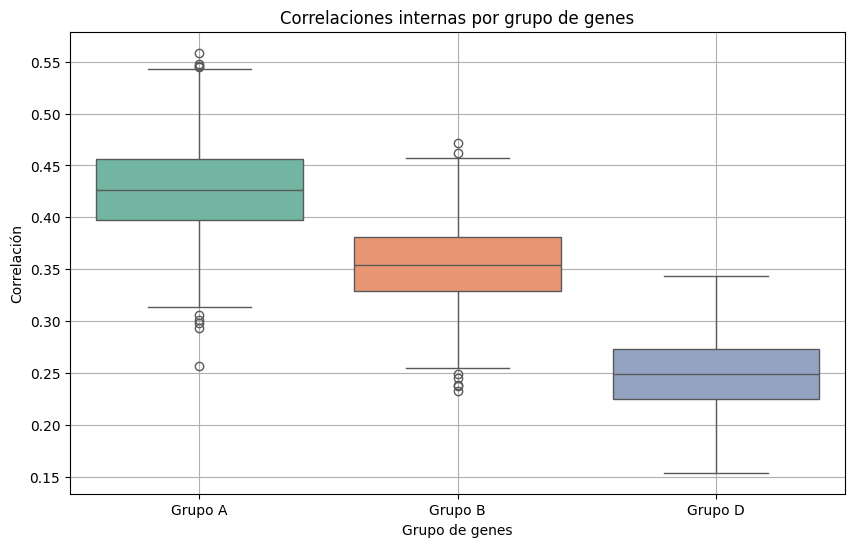

In [11]:
# Selecciona los genes por grupo
genes_A = [f'A_gene{i}' for i in range(1, 101)]
genes_B = [f'B_gene{i}' for i in range(1, 201)]
genes_D = [f'D_gene{i}' for i in range(1, 301)]

# Función para calcular correlaciones internas de un grupo
def obtener_correlaciones_internas(df, lista_genes):
    matriz_corr = df[lista_genes].corr().values
    # Extraer solo la parte superior del triángulo sin la diagonal
    corr_vals = matriz_corr[np.triu_indices_from(matriz_corr, k=1)]
    return corr_vals

# Calcular correlaciones para cada grupo
corr_A = obtener_correlaciones_internas(df_final, genes_A)
corr_B = obtener_correlaciones_internas(df_final, genes_B)
corr_D = obtener_correlaciones_internas(df_final, genes_D)

# Crear DataFrame para el boxplot
df_corrs = pd.DataFrame({
    'Correlación': np.concatenate([corr_A, corr_B, corr_D]),
    'Grupo': (['Grupo A'] * len(corr_A)) + (['Grupo B'] * len(corr_B)) + (['Grupo D'] * len(corr_D))
})

# Visualización
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_corrs, x='Grupo', y='Correlación', palette='Set2')
plt.title("Correlaciones internas por grupo de genes")
plt.grid(True)
plt.xlabel("Grupo de genes")
plt.ylabel("Correlación")
plt.show()

Los resultados de los BoxPlots confirman:

**Grupo A**
- La media de las correlaciones entorno 0.42-0.43
- Rango amplio, pero dentro del intervalo esperado [0.3,0.6]
    
**Grupo B**
- Correlaciones medias más bajas que en el grupo `A`(sobre el 0.36), como era de esperar ya que su rango de correlación es menor.

- Coherente con el rango simulado [0.2, 0.4], aunque hay valores que alcanzan valores mayores, entorno a 0.45, se considera que son outliers.

**Grupo D**

- Muestra correlaciones internas más bajas, media entorno a 0.25. Hay valores que se salen algo fuera de rango [0.2,0.3], pero al no salirse mucho no es preocupante
    
- Su estructura es más débil, como se definió en la simulación

El gráfico valida que la simulación de la estructura de las correlaciones internas por grupo se ha realizado correctamente. Cada grupo refleja las características que definimos en la matriz de correlación inicial **Sigma**. El resultado es coherente con el diseño experimental y respalda la calidad de los datos generados.



### Análisis de multicolinealidad mediante VIF

En problemas de predicción multivariables es importante verificar que los predictores no estén excesivamente correlacionados entre sí.

Cuando existe una fuerte correelación entre variables independientes, se produce **multicolinealidad**, lo que puede distorsionar las estimaciones de los coeficientes de un modelo y afectar negativamente a su interpretación y su rendimiento.

Para cuatificar este fenómeno, se utiliza el **Variance Inflation Factor (VIF)**, que mide cuánto se infla la varianza estimada de un coeficiente debido a la colinealidad con otras variables.

El **VIF** se define como:
$$
VIF_i = \frac{1}{1 - R_i^2}
$$

donde $R_i^2$ es el coeficiente de determinación de la variable $i$ contra todas las demás.

**Interpretación estándar del VIF:**

- **VIF ≈ 1**: No hay colinealidad.
- **VIF entre 1 y 5**: Colinealidad moderada (generalmente aceptable).
- **VIF > 5**: Colinealidad significativa (puede ser problemática).
- **VIF > 10**: Colinealidad severa (sugiere considerar eliminar o transformar variables).

En este análisis, voy a calcular **VIF** para las variable clínicas y los genes más relevantes con el fin de evaluar si existe un nivel preocupante de colinealidad en los datos

/tmp/ipykernel_6748/2844600482.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grupo', y='VIF', data=vif_data, palette='Set2')


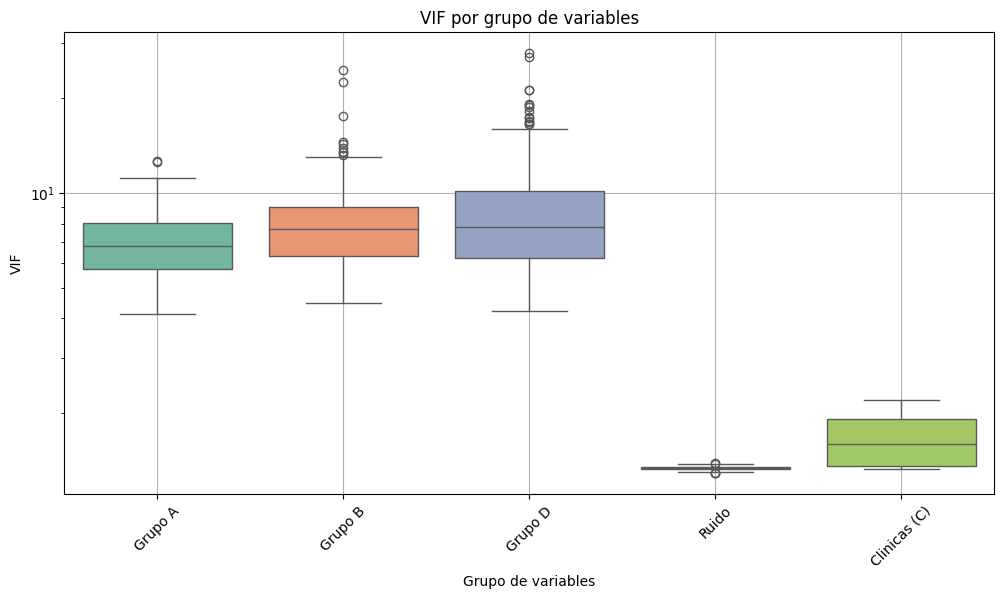

In [12]:

#Selección de variables
genes_A= [f'A_gene{i}' for i in range(1, 101)]
genes_B= [f'B_gene{i}' for i in range(1, 201)]
genes_D= [f'D_gene{i}' for i in range(1, 301)]
genes_ruido= [f'Noise_gene{i}' for i in range(1, 401)]
variables_clinicas= ['edad', 'sexo', 'rin', 'lote']

variables_vif= genes_A + genes_B + genes_D + genes_ruido + variables_clinicas
variables_para_vif= df_final[variables_vif]

#Estandaarizar
X_scaled= StandardScaler().fit_transform(variables_para_vif)

#Calcular VIF
vif_data= pd.DataFrame()
vif_data["Variable"]= variables_para_vif.columns
vif_data["VIF"]= [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

#Clasifico las variables en grupo
def clasificar_variable(nombre):
    if nombre in ['edad', 'sexo', 'rin', 'lote']:
        return 'Clinicas (C)'
    elif nombre.startswith('A_gene') and 1 <= int(nombre.replace('A_gene', '')) <= 100:
        return 'Grupo A'
    elif nombre.startswith('B_gene') and 1 <= int(nombre.replace('B_gene', '')) <= 200:
        return 'Grupo B'
    elif nombre.startswith('D_gene') and 1 <= int(nombre.replace('D_gene', '')) <= 300:
        return 'Grupo D'
    else:
        return 'Ruido'
vif_data['Grupo']= vif_data['Variable'].apply(clasificar_variable)

#Visualizo todo en un Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Grupo', y='VIF', data=vif_data, palette='Set2')
plt.title('VIF por grupo de variables')
plt.xlabel('Grupo de variables')
plt.ylabel('VIF')
plt.xticks(rotation=45)
plt.grid(True)
plt.yscale('log')
plt.show()

Los resultados obtenidos indican:
- **Grupo A**:
    
    - El **VIF** es moderadamente alto

    - Esto es coherente con lo esperado, estos genes tienen correlación interna y además colinealidad con la variable edad, lo que como es lógico aumenta el **VIF**
    
    - La dispersión del **VIF** también refleja que no todos los genes del **grupo A** están igualmente correlacionados con la edad o entre ellos
- **Grupo B**

    - Se observa un patrón muy similar al de `A`, con valores de **VIF** también elevados.

    - Al igual que en `A`, la colinealdiad proviene de la influencia común de una variable de **C (Sexo)** y de las correlaciones internas dentro del grupo

    - La ligera mayor dispersión sugiere que algunos genes podrían estar más influenciados que otros
- **Grupo D**

    - Este grupo muestra un **VIF más alto que en A y B** en muchos casos

    - Esto se explica porque toda la colinealidad de `D` es puramente interna, entre genes, sin estar explicada por una variable de `C`.

    - Por tanto, `D` presenta multicolinealidad fuerte sin confusión con covariables clínicas.

- **Ruido**
    
    - Este grupo muestra **VIF muy bajo**, centrado en torno a 1, como cabría esperar.

    - La ausencia de correlación interna ni con `C` asegura que no haya multicolinealidad significativa

    - Sirve como grupo de control

- **Variable clínicas C (edad, sexo, lote, RIN)**

    - El **VIF también es bajo**, lo que indica que las variable clínicas no están altamente correlacionadas entre sí.
    
    - Esto es deseable, ya que no queremos que represente factores independientes en el modelo casual

Este análisis de **VIF** cumple perfectamente con las condiciones impuestas durante la simulación:

- Los grupos `A` y `B` presentan colinealidad por su dependencia con variable clínicas `C`

- El grupo `D` presenta colinealidad interna no explicada por `C`

- El grupo de `ruido` está bien definido, sin correlación

- Las variables clíncias `C` están correctamente simuladas como variable independientes.

Esto valida que la estructura **C → M’ → Y** se ha simulado correctamente





### Análisis sobre la Variable Y

En esta sección vamos a **explorar en profundidad la variable objetivo Y**, que representa la presencia o ausencia de enfermedad de Alzheimer, para entender mejor **cómo se relaciona con las variables clínicas (`C`) y con los genes simulados (`M`). Este análisis es importante por varias razones:

-**Detectar relaciones espurias o sesgos**: Como `Y` ha sido definida parcialmente en función de algunas variables clínicas (`edad` y `sexo`) y de algunos subconjuntos de genes (`A`,`B`), es fundamental comprobar si estas relaciones se reflejan correctamente en los datos simulados. Además, queremos asegurarnos de que otras variables como (`rin` o `lote`) no estén introduciendo señales falsas.

-**Visualizar patrones**: Las comparaciones gráficas permiten identificar si los valores de variables como `edad`, `sexo` o ciertos grupos de genes se distribuyen de forma diferente entre individuos sanos y enfermos.

-**Confirmar las relaciones definidas en el simulador**: Por diseño:
- **Edad** está correlacionada con `Y` (0.3)
- **Sexo** también correlacionada con `Y` (0.1)
- Los genes del grupo `A` están influenciados por `edad` y correlacionados con `Y` (0.2)
- Los genes del grupo `B` están influenciados por `sexo` y correlacionados con `Y` (0.5)
- Los grupos `D` y `Ruido` no deberían estar relacionados con `Y`.

#### Objetivos del análisis

-Examinar la asociación entre `sexo` e `Y` mediante una **tabla de contingencia** y un **test-chi-cuadrado**

-Visualizar la distribución de variables numéricas (`edad`, `rin`) según el valor de `Y` con **boxplots**

-Comprobar si los patrones de expresión génica difieren entre clases (`Y = 0` vs `Y = 1`) en cada grupo de genes (`A`, `B` y `D`) usando **gráficos de caja agrupados**.


#### Matriz de Contingencia y Test Chi-cuadrado

Este primer análisis consiste en generar una **tabla de contingencia** que muestre cuántos individuos sanos y enfermos hay en cada categoría de `sexo`. Este tipo de tablas nos permite observar patrones como si hay más prevalencia de enfermedad en un sexo u otro

Posteriormente, aplicamos un **test chi-cuadrado de independencia** para evaluar si existe asociación estadística significativa entre las variables `sexo` y `alzheimer`. Este test es especialmente útil cuando ambas variables son categóricas y nos permite validad si la diferencia observada es atribuible al azar o a una relación real en los datos. 

Este paso es importante porque, aunque se inyectó una correlación moderada (`r = 0.1`) entre `sexo` y `Y`, necesitamos verificar si esta señal es lo suficientemente fuerte como para detectarse estadísticamente y si puede actuar como variable confusora.


Chi² = 893.114, p-value = 0.0000, grados de libertad = 1
Frecuencias esperadas: 
 Alzheimer       0       1
sexo                     
0          1010.0  1010.0
1           990.0   990.0


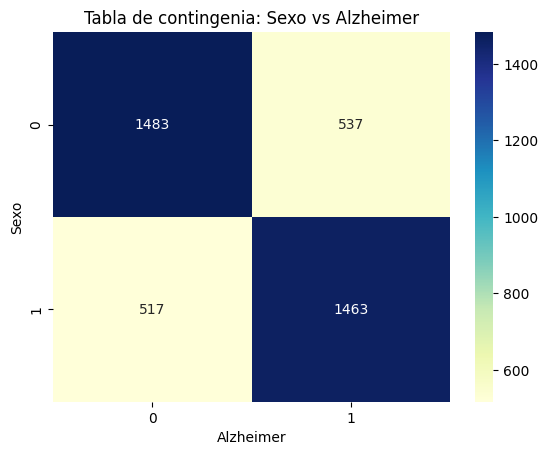

In [13]:

#Tabla de contingencia
contingencia = pd.crosstab(df_final['sexo'], df_final['Alzheimer'])

#Test chi-cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingencia)
print(f"\nChi² = {chi2:.3f}, p-value = {p:.4f}, grados de libertad = {dof}")
print("Frecuencias esperadas: \n", pd.DataFrame(expected, index=contingencia.index, columns=contingencia.columns))

#Visualización de la tabla de contingencia
sns.heatmap(contingencia, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Tabla de contingenia: Sexo vs Alzheimer")
plt.xlabel("Alzheimer")
plt.ylabel("Sexo")
plt.show()

##### Resultados

La tabla de conntingencia muestra: 

| Sexo        | Alzheimer = 0 | Alzheimer = 1 |
| ----------- | ------------- | ------------- |
| 0 (hombres) | 1,483         | 537           |
| 1 (mujeres) | 517           | 1,463         |

Esto indica que:

- Entre los **hombres** hay más casos **sin** ALzheimer que **con**

- Entre las **mujeres** es al revés, hay más casos **con** Alzheimer.

Esto ya indica **una asociación entre el sexo y la variable Alzheimer**. Las mujeres están más representadas en el grupo Alzheimer, y los hombres en el grupo control

Las frecuencias esperados baja condiciones independientes:

| Sexo     | Esperado 0 | Esperado 1 |
| ---------- | ---------- | ---------- |
| Hombre (0) | 1010       | 1010       |
| Mujer (1)  | 990        | 990        |

Son las frecuencias que se **esperaría**  ver si **no existiera relación** entre sexo y diagnóstico, pero como se puede observar nuestro resultado difiere bastente de el resultado bajo condiciones independientes.

Las resultados del test chi-cuadrado son:
- Chi² = 893.114
- p-value ≈ 0.0000
- Grados de libertadad = 1

Este valor tan elevados del estadístico chi-cuadrado y un p-valor prácticamente nulo indican que la **hipótesis nula de independencia entre sexo y Alzheimer se rechaza**. Es decir, **existe una asociación estadísticamente significativa entre el sexo y el diagnóstico simulado de Alzheimer**. 

Este resultado es **coherente con el diseño simulado**, ya que:

- Se definió que la variable Y **tuviera una correlación de 0.1 con sexo**
- Aunque esta correlación no es muy fuerte, el tamaño muestra de 4000 sujetos **amplifica su efecto**, haciendo que incluso asociaciones moderadas sean estadísticamente significativas.

#### Análisis de distribución de variables por grupo de diagnóstico `Y`

En esta sección se va a explorar **como varían distintas variables clínicas y grupos de genes** en función del estado de la enfermedad `Y`. Para ello, se van a generar **gráficos de caja** que permiten comparar la **distribución** de una variable continua en función de una variable categórica, que en este caso va a ser `Y`.

Para cada una de las siguientes variables vamos a generar un **boxplot agrupado por el valor de `Y`**:

- **Edad**: Esperamos a ver diferencias claras, ya que introdujimos una correlación entre edad e `Y` de 0.3

- **RIN**: No debería mostrar diferencias, porque no tiene relación causal ni con `M` ni con `Y`.

- **Genes del grupo A**: Correlacionados con edad y a su vez relacionados con `Y`, debería haber diferencias.

- **Genes del grupo B**: Correlacionados con sexo, y también vinculado a `Y`, también se espera que haya cierta separación.

- **Genes del grupo D**: Con correlación interna pero no relacionados con ninguna variable clínica ni con `Y`, por lo que no se debería observar diferencias significativas.

La utilidad de este análisis radica en que nos permite **verificar visualmente** si las relaciones causales que se han definido en el simulador se reflejan en los datos generados. Es una forma de **validad la coherencia del dataset simulado** antes de usarlo para otros fines como el entrenamiento de modelos. Además, ayuda a **entender que variables pueden ser informativas** para predecir `Y`, incluso antes de usar métodos de importancia de variables.

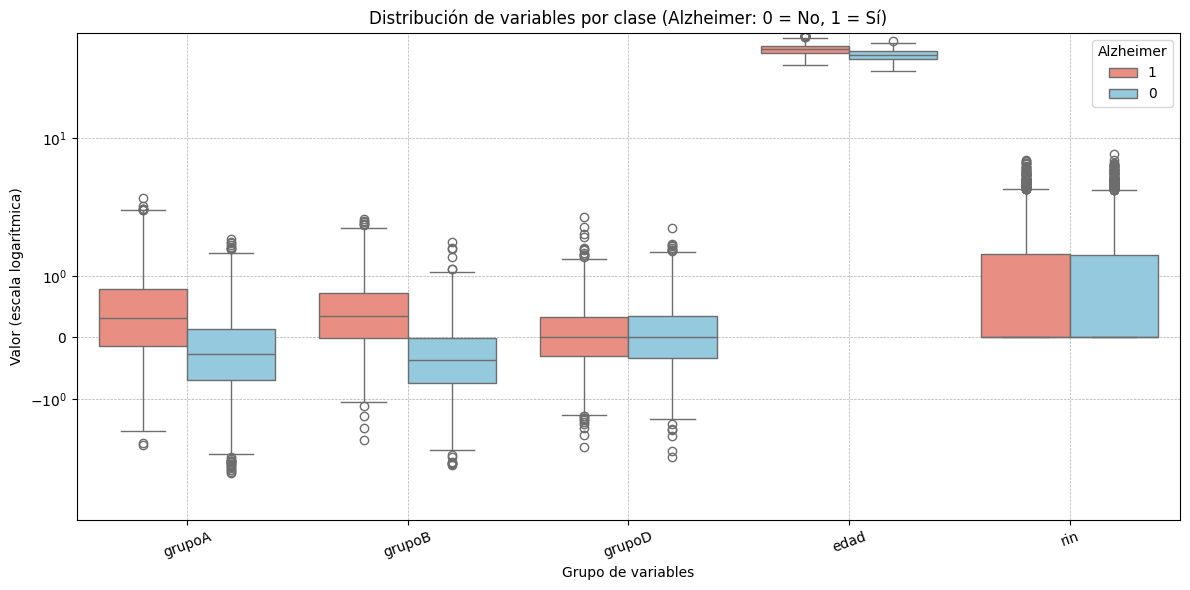

In [14]:

# Calcular media por grupo
df_final['grupoA'] = df_final[[f"A_gene{i}" for i in range(1, 101)]].mean(axis=1)
df_final['grupoB'] = df_final[[f"B_gene{i}" for i in range(1, 201)]].mean(axis=1)
df_final['grupoD'] = df_final[[f"D_gene{i}" for i in range(1, 301)]].mean(axis=1)

df_plot = df_final[["Alzheimer", "grupoA", "grupoB", "grupoD", "edad", "rin"]].copy()

df_long= df_plot.melt(id_vars="Alzheimer", var_name="Variable", value_name="Valor")
df_long["Alzheimer"] = df_long["Alzheimer"].astype(str)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_long, x="Variable", y="Valor", hue="Alzheimer",
    palette={"0": "skyblue", "1": "salmon"}
)
plt.yscale("symlog")  
plt.title("Distribución de variables por clase (Alzheimer: 0 = No, 1 = Sí)")
plt.xlabel("Grupo de variables")
plt.ylabel("Valor (escala logarítmica)")
plt.xticks(rotation=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

##### Resultados

-**GrupoA (Genes A)**

- Se observa unna diferencia clara en la distribución media de expresión entre casos y controles

- Esto es **coherente** con el diseño de la simulación, ya que los genes A están correlacionados con edad, que a su vez está asociada a `Y` (p = 0.3).

- Además, `A` está directamente asociada con `Y` (p = 0.2), por lo que es lógico que se observe mayor o por lo menos diferente expresión en **Alzheimer**

-**GrupoB (Genes B)**

- También muestra diferencias claras en la expresión de las clases

- Tiene sentido porque `B` está muy correlacionado con **sexo**, que tiene una leve relación con `Y`(p = 0.1)

- Además, **B tiene una correlación fuerte directa con Y** (p = 0.5)

- Esto explica que el grupo B tenga una señal diferenciadora clara

-**GrupoD (genes D)**

- Aquí como se observa, la diferencia es mucho más tenue o incluso nula.

- Como se esperaba, el grupo D **no está correlacionado ni con ninguna variable C ni con Y**, por lo que es normal que no haya una separación clara entre las clases

- Su comportamiento actúa como **control negativo** del sistema.

-**Edad**

- Diferencia clara entre las clases: Los casos postitivos tienen valores de edad visiblemente mayores

- Esto es esperado, ya que **edad está correlacionado con Y (p = 0.3)**, además de estar implicada en la generación de los **genesA**

-**RIN**

- Como se observa `RIN` no muestra diferencias entre los casos postitivos y los casos negativos

- Esto es lo esperado, ya que **RIN no influye en la generación de genes ni en la variable objetivo Y**, por lo tanto es normal que no haya diferencias entre casos y controles

Por lo tanto, este gráfico en general **valida muy bien** el comportamiento esperado seguń el diseño del simulador. Los grupos diseñados para influir en `Y` **A,B y edad** muestran diferencias claras, mientras que los grupos neutrales como **D y RIN** no muestran diferencias sustanciales. Esto refuerza la idea de que los modelos están **captando las señales verdaderamente informativas**

### Conclusión

En este notebook se ha desarrollado un generador de datos sintéticos con una estructura casual definida, simulando un contexto biomédico realista donde algunas variables clínicas `C` afectan a subconjuntos de genes `M'`, los cuales a su vez determinan una variable binaria de enfermedad `Y`.

Se diseñó cuidadosamente la matriz de expresión génica `M` para incluir grupos de genes con distinta estructura de correlación interna y conexión casual con `C`. También se ha añadido ruido (genes sin relación casual) para reflejar situaciones reales en estudios ómicos.

La correcta introducción de las correlaciones fue validada tanto mediante medias de correlación promedio con mediante el cálculo del **Variance Inflation Factor (VIF)**, asegurando que las dependencias estructurales esperadas están presentes en los datos.

Los análisis exploratorios realizados sobre el dataset simulado confirma que la variable `Y` mantiene relaciones estructurales coherentes con las variables clíicas y génicas utilizadas para su generación. Por ejemplo, el **boxplots de edad según Y** muestra claras diferencias entre clases, el línea con las correlaciones inyectadas explícitamente en el simulador (edad → genes A, sexo → genes B, edad y sexo → Y).

Asimismo, los resultados del **test Chi-cuadrado** aplicado sobre la matriz de contingencia entre `sexo` e `Y` evidencian una asociación estadísitica signifificativa entre ambas variables, como se esperaba por construcción. Por el contrario, variables diseñadas como irrelevantes (`RIN`) no muestran diferencias apreciables entre las clases, lo que refuerza la validez del diseño del simulador y su utilidad como banco de pruebas para identificar efectos casuales frente a asociaciones espurias.

Esta combinación de control casual, ruido controlado y verificación empírica convierte al dataset en una **herramienta valiosa para estudiar el impacto de los variables clínicas confusoras en modelos predictivos**, permitiendo evaluar estrategias de ajuste como el uso del parámetro `always.split.variable` o la comparación entre diferentes configuraciones de variables clinicas y ómicas.

In [15]:
df_final.to_csv('datos_simulados.csv', index=False)
print("Datos simulados guardados en 'datos_simulados.csv'")

Datos simulados guardados en 'datos_simulados.csv'
